## Monte Carlo

##### Utilizar o teste de Monte Carlo para calcular o erro nas estimativas da aba maturação do modelo Achilles
 

In [1]:
# Importação e concatenagem das planilhas de output da aba Maturação
# Exclusão de oultliers dos valores de input (definição de valores extremos para teste de Monte Carlo)
# Definição de Valores máximos e mínimos para simulação de poços
# Simulação de Poços
# Cálculo de médias por parâmetro
# Distribuição Gaussiana das médias de poços simulados

In [2]:
%matplotlib inline
import random
import os
import pandas as pd
import scipy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from matplotlib.gridspec import GridSpec
import matplotlib.patches as patches
import skfuzzy as fuzz 
from skfuzzy import control as ctrl
from tqdm.auto import tqdm
from IPython.core.magic import register_cell_magic


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/rodrigo/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Formatação dos gráficos

custom_style = {
    'figure.figsize': (8.77, 6.2),
    'font.family':'sans-serif',
    'axes.facecolor': 'white',
    'figure.facecolor':'lightgray',
    'scatter.marker': 'o',
    'font.size': 9,
    'axes.grid': True
    }

### Importação e concatenagem dos poços reais

In [4]:
directory_path = "Poços_Marinho"
csv_files = [file for file in os.listdir(directory_path) if file.endswith('.csv')] 

dataframes = []

for csv_file in csv_files:                              # Concatenagem das planilhas importadas
    file_path = os.path.join(directory_path, csv_file)
    df = pd.read_csv(file_path)
    dataframes.append(df)
concat_df= pd.concat(dataframes, ignore_index=True)
concat_df

,Poço,Profundidade,COT,S1,S2,S3,Tmax,Ro,IH,IO,MESA_ROTATIVA,LAMINA_D_AGUA_M,TMax
0,1-RNS-37-RN,2753.0,0.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1-RNS-37-RN,2758.7,1.66,0.15,2.72,0.20,435.0,NaN,163.86,12.05,NaN,NaN,NaN
2,1-RNS-37-RN,2858.0,2.11,0.15,6.37,0.36,430.0,NaN,301.90,17.06,NaN,NaN,NaN
3,1-RNS-37-RN,2896.0,0.16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1-RNS-37-RN,1087.0,1.30,0.23,0.79,0.93,431.0,NaN,60.77,71.54,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17575,1-ESS-38-ES,2324.0,1.21,0.07,0.40,1.20,409.0,NaN,33.06,99.17,NaN,NaN,NaN
17576,1-ESS-38-ES,2339.0,0.53,0.07,0.26,0.39,408.0,NaN,49.06,73.58,NaN,NaN,NaN
17577,1-ESS-38-ES,2354.0,0.92,0.08,0.43,0.21,410.0,NaN,46.74,22.83,NaN,NaN,NaN
17578,1-ESS-38-ES,2369.0,1.14,0.06,0.32,0.52,407.0,NaN,28.07,45.61,NaN,NaN,NaN


### Exclusão de oultliers dos valores de input (definição de valores extremos para teste de Monte Carlo)

In [5]:
df_input=concat_df[["COT","S1","S2","S3","IH","IO","Tmax"]]#,"COTa","COT0","S20","IH0"]]
def exclude_outliers_dataframe(df_input, threshold=1.5):
    Q1 = df_input.quantile(0.25)
    Q3 = df_input.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR
    outliers = (df_input < lower_bound) | (df_input > upper_bound)
    df_no_outliers = df_input[~outliers]
    return df_no_outliers
df_no_outliers = exclude_outliers_dataframe(df_input)


### Correlações entre parâmetros

In [6]:
corr_df=df_no_outliers[["COT","S1","S2","S3","IH","IO","Tmax"]]#,"COTa","COT0","S20","IH0"]]
corr_df.corr()

,COT,S1,S2,S3,IH,IO,Tmax
COT,1.000000,0.238802,0.497202,0.035375,0.225485,-0.344629,0.129802
S1,0.238802,1.000000,0.372167,0.110468,0.368659,-0.091148,0.129547
S2,0.497202,0.372167,1.000000,-0.011376,0.835771,-0.206128,0.257658
S3,0.035375,0.110468,-0.011376,1.000000,-0.082051,0.780757,-0.382520
IH,0.225485,0.368659,0.835771,-0.082051,1.000000,-0.178977,0.206550
IO,-0.344629,-0.091148,-0.206128,0.780757,-0.178977,1.000000,-0.356578
Tmax,0.129802,0.129547,0.257658,-0.382520,0.206550,-0.356578,1.000000


### Definição de Valores máximos e mínimos para simulação de poços

In [7]:
# Máximos e mínimos com outliers excluídos

quant=["COT","S1","S2","S3","Tmax","IH","IO"]
Maximos=[]
Minimos=[]
Medias=[]
Mediana=[]
DesvPad=[]
for i in quant:
    max=df_no_outliers[i].max()
    min=df_no_outliers[i].min()
    av=df_no_outliers[i].mean().round(2)
    mdn=df_no_outliers[i].median()
    desvpad=df_no_outliers[i].std()
    Maximos.append(max)
    Minimos.append(min)
    Medias.append(av)
    Mediana.append(mdn)
    DesvPad.append(desvpad)
frame=pd.DataFrame(quant)
frame["Máximos"]=Maximos
frame["Mínimos"]=Minimos
frame["Médias"]=Medias
frame["Medianas"]=Mediana
frame

,0,Máximos,Mínimos,Médias,Medianas
0,COT,2.67,0.01,1.00,0.88
1,S1,1.68,0.01,0.38,0.22
2,S2,8.60,0.01,2.19,1.58
3,S3,3.85,0.00,1.28,1.12
4,Tmax,458.00,410.00,434.46,434.00
5,IH,581.40,0.83,178.12,138.17
6,IO,326.39,0.00,96.84,76.72


In [8]:
# Máximos de mínimos de lâmina d'água

df_lagua = pd.read_csv("Nomes_GIS1.csv")
lagua_max = df_lagua["LAMINA_DAGUA"].max()
lagua_min = df_lagua["LAMINA_DAGUA"].min()
print(lagua_max, lagua_min)



2321.0 5.0


# Simulação de poços

In [9]:
def simulação():
    cont = 0
    n = 10000
    nome=[]
    while cont < n:
        
        for i in np.arange(n):
            i = f"Poço_{cont+1}"
        nome.append(i)

        # Geração de amostra
        
        min_values = [0.01, 0.01, 0.01, 0.00, 405,1.0]  # Definição de máximos e mínimos
        max_values = [2.67,1.7, 8.6, 3.9, 460,580]
        df = pd.DataFrame({"Min": min_values, "Max": max_values})

        # Geração de poço

        quant = int(random.uniform(10, 100))
        poço = []
        COTf = []
        A1 = []
        for index, row in df.iterrows():
            i = row["Min"]
            j = row["Max"]
            rand = [random.uniform(i, j) for _ in range(quant)]
            poço.append(rand)
        for x in range(quant): 
            px = float(random.uniform(0,100))                 #Calculo de COT por frequência
            if px <= 95:
                x = float(random.uniform(0,2.9))
            elif px > 95 and px <= 97.5:
                x = float(random.uniform(2.9,4.0))
            elif px > 97.5 and px < 99: 
                x = float(random.uniform(4.0,6.0))
            elif px > 99 and px < 99.75:
                x = float(random.uniform(6.0,10))
            else:
                x = float(random.uniform(0,10))
            #cotf = [x for _ in range(quant)]
            COTf.append(x)
            if x > 4:
                py = float(random.uniform(0,100))
                if py <=50:
                    a1 = float(random.uniform(4.85,7.35))
                elif py > 50 and py < 60:
                    a1 = float(random.uniform(7.35, 10))
                else:
                    a1 = float(random.uniform(0,4.85))
            elif x > 2.9 and x <= 4:
                y = float(random.uniform(0,100))
                if py <= 25:
                    a1 = float(random.uniform(4.85,7.35))
                elif py > 25 and py < 90:
                    a1 = float(random.uniform(0,4.85))
                else:
                    a1 = float(random.uniform(7.35,10))
            else:
                py = float(random.uniform(0,100))
                if py <=55.6:
                    a1 = float(random.uniform(0,4.85))
                elif py >55.6 and py < 99.9: 
                    a1 = float(random.uniform(4.85,7.35))
                else:
                    a1 = float(random.uniform(7.35,10))
            A1.append(a1)

            
        Poço_df = pd.DataFrame(poço).transpose()

        Poço_df[["COT","S1","S2","S3","Tmax","IH"]]=Poço_df[[0,1,2,3,4,5]]
        Poço_df["COTf"] = COTf
        Poço_df["IO"]=Poço_df["S3"]/Poço_df["COT"]

        Poço_df["S2pi"] = A1*Poço_df["COTf"]
        Poço_df["IHf"] = (Poço_df["S2pi"]/Poço_df["COTf"])*100

        
        Poço=(Poço_df[["COTf","COT","S1","S2","S3","Tmax","IH","IO","S2pi","IHf"]]).round(2)

        Poço.to_csv(f"Poços_Simulados/Poço_{cont + 1}.csv")
        
        cont += 1
   
#simulação()

In [10]:
#Calculo de COT por frequência
#poço = pd.DataFrame()
#p = int(random.uniform(0,100))
#if p <= 95:
#    n = float(random.uniform(0,2.7))
#elif p > 95 and p < 98.5:
#    n = float(random.uniform(2.7,4.0))
#else:
#    n = float(random.uniform(4.0,5.0))*0.015
#
#poço = n
#poço


## Fazer histograma de COTf...

### Importação e concatenagem de poços simulados

In [11]:
dataframes=[]
diretorio="Poços_Simulados"
csv_files = [file for file in os.listdir(diretorio) if file.endswith('.csv')]   # Lista com os nomes de todos os arquivos importados
for csv_file in csv_files:
    file_path = os.path.join(diretorio, csv_file)
    df = pd.read_csv(file_path)
    dataframes.append(df)
df_cnc= pd.concat(dataframes, ignore_index=True)
#concat_df.to_csv("Concat.csv")
df_cnc

,Unnamed: 0,COTf,COT,S1,S2,S3,Tmax,IH,IO,S2pi,IHf
0,0,0.34,2.00,1.05,7.51,2.21,443.21,564.87,1.10,1.05,304.94
1,1,9.94,0.37,1.57,5.13,1.46,409.49,127.06,3.91,63.26,636.30
2,2,0.01,2.43,1.35,2.15,3.77,407.66,433.92,1.55,0.03,196.24
3,3,1.80,2.30,0.69,5.32,1.13,449.40,541.28,0.49,2.63,145.92
4,4,0.00,0.05,1.22,4.17,0.86,432.70,253.72,17.92,0.00,37.43
...,...,...,...,...,...,...,...,...,...,...,...
542887,34,0.59,0.18,0.27,0.08,0.68,453.53,109.79,3.76,0.64,109.35
542888,35,0.35,0.54,1.44,6.83,2.80,429.93,247.68,5.20,0.87,246.47
542889,36,0.35,0.29,1.57,4.97,2.20,421.62,560.88,7.69,0.18,51.08
542890,37,1.17,1.12,1.44,2.64,2.47,433.11,426.80,2.19,1.34,115.01


In [12]:
#plt.scatter(df_cnc["COT"],df_cnc["S2"], c="darkcyan", s=0.5, edgecolor="black", linewidth=0.03)
#plt.xlabel("COT",fontsize=11)
#plt.ylabel("S2",fontsize=11)

In [13]:
#plt.scatter(df_cnc["COTf"],df_cnc["S2pi"], c="darkcyan", s=0.5, edgecolor="black", linewidth=0.03)
#plt.xlabel("COT",fontsize=11)
#plt.ylabel("S2",fontsize=11)

In [14]:
#plt.scatter(concat_df["COT"],concat_df["S2"], c="dimgray",s=2,edgecolor="black", linewidth=0.3)
#plt.xlim(0,10)
#plt.ylim(0,100)
#plt.xlabel("COT",fontsize=11)
#plt.ylabel("S2",fontsize=11)

Text(0, 0.5, 'IH')

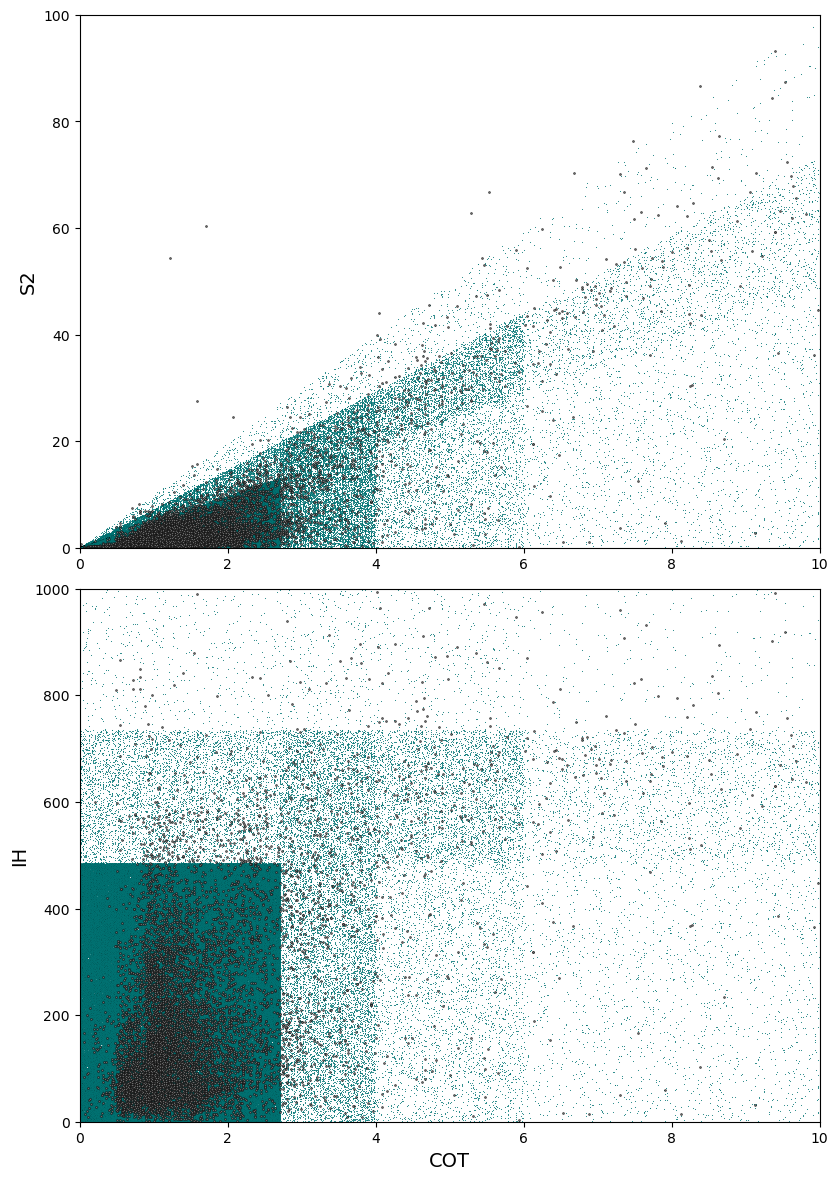

In [15]:

#fig1, ax=plt.subplots()
a4_width = 8.27  # inches
a4_height = 11.69  # inches

fig = plt.figure(figsize=(a4_width, a4_height), layout='constrained')

L1 = GridSpec(2,1, figure=fig)#, width_ratios=[1, 1,1,1], height_ratios=[1,1, 1])

ax1 = fig.add_subplot(L1[0,0])
ax2 = fig.add_subplot(L1[1,0])
plt.style.use(custom_style)

ax1.scatter(df_cnc["COTf"],df_cnc["S2pi"], c="darkcyan", s=0.5, edgecolor="black", linewidth=0.03)
ax1.scatter(concat_df["COT"],concat_df["S2"],c="dimgray",s=2,edgecolor="black", linewidth=0.3)
#ax.scatter(df_cnc["COT"],df_cnc["S2pi3"],alpha=0.005, c="darkred")
ax1.set_xlim(0,10)
ax1.set_ylim(0,100)
ax1.set_ylabel("S2",fontsize=14)


ax2.scatter(df_cnc["COTf"],df_cnc["IHf"], c="darkcyan", s=0.5, edgecolor="black", linewidth=0.03)
ax2.scatter(concat_df["COT"],concat_df["IH"],c="dimgray",s=2,edgecolor="black", linewidth=0.3)
#ax.scatter(df_cnc["COT"],df_cnc["S2pi3"],alpha=0.005, c="darkred")
ax2.set_xlim(0,10)
ax2.set_ylim(0,1000)
ax2.set_xlabel("COT",fontsize=14)
ax2.set_ylabel("IH",fontsize=14)


#ax1.set_xlim(0,1000)
#ax.set_xlabel("S2", fontsize=14)
#ax.grid(False)


#### Médias de parâmetros de poços simulados

In [16]:
media_ih=[]
for csv_file in csv_files:
    file_path = os.path.join(diretorio, csv_file)
    df = pd.read_csv(file_path)
    avg = df["IHf"].mean()
    media_ih.append(avg)

media_cot=[]
for csv_file in csv_files:
    file_path = os.path.join(diretorio, csv_file)
    df = pd.read_csv(file_path)
    avg = df["COTf"].mean()
    media_cot.append(avg)

media_spi=[]
for csv_file in csv_files:
    file_path = os.path.join(diretorio, csv_file)
    df = pd.read_csv(file_path)
    avg = df["S2pi"].mean()
    media_spi.append(avg)


In [17]:

#fig, ax1=plt.subplots()
#bins = 1000
#hist, bins = np.histogram(media_ih, bins)
#ax1.hist(media_ih,bins, facecolor="darkcyan", alpha=0.7)
#ax1.set_xlabel("IHf", fontsize=14)
#plt.style.use(custom_style)
#
#fig, ax2=plt.subplots()
#bins = 1000
#hist, bins = np.histogram(media_cot, bins)
#ax2.hist(media_cot,bins, facecolor="darkcyan", alpha=0.7)
#ax2.set_xlabel("COTf", fontsize=14)
#plt.style.use(custom_style)
#
#fig, ax3=plt.subplots()
#bins = 1000
#hist, bins = np.histogram(media_spi, bins)
#ax3.hist(media_spi,bins, facecolor="darkcyan", alpha=0.7)
#ax3.set_xlabel("S2pi", fontsize=14)
#plt.style.use(custom_style)


### Distribuição Gaussiana das médias de poços simulados

In [18]:
#mu = np.mean(df_cnc["IHf"])
#sigma = np.std(df_cnc["IHf"])
#fig, ax=plt.subplots()
#bins = 1000
#hist, bins = np.histogram(media, bins)
##y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
##     np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
#ax.hist(media,bins)
#ax.set_xlabel("IHf", fontsize=14)
#plt.style.use(custom_style)
##ax.plot(bins, y, '--')

### Comparação entre poços simulados e reais

In [19]:
# Importação de poços reais
dataframes2=[]
directory_path = "Poços_Marinho"
csv_files = [file for file in os.listdir(directory_path) if file.endswith('.csv')]   # Lista com os nomes de todos os arquivos importados
for csv_file in csv_files:
    file_path = os.path.join(directory_path, csv_file)
    df = pd.read_csv(file_path)
    dataframes2.append(df)
concat_df= pd.concat(dataframes2, ignore_index=True)

# Cálculo das médias de poços reais

media_real_ih=[]
for csv_file in csv_files:
    file_path = os.path.join(directory_path, csv_file)
    df = pd.read_csv(file_path)
    avg = df["IH"].mean()
    media_real_ih.append(avg)

media_real_cot=[]
for csv_file in csv_files:
    file_path = os.path.join(directory_path, csv_file)
    df = pd.read_csv(file_path)
    avg = df["COT"].mean()
    media_real_cot.append(avg)

media_real_s2=[]
for csv_file in csv_files:
    file_path = os.path.join(directory_path, csv_file)
    df = pd.read_csv(file_path)
    avg = df["S2"].mean()
    media_real_s2.append(avg)



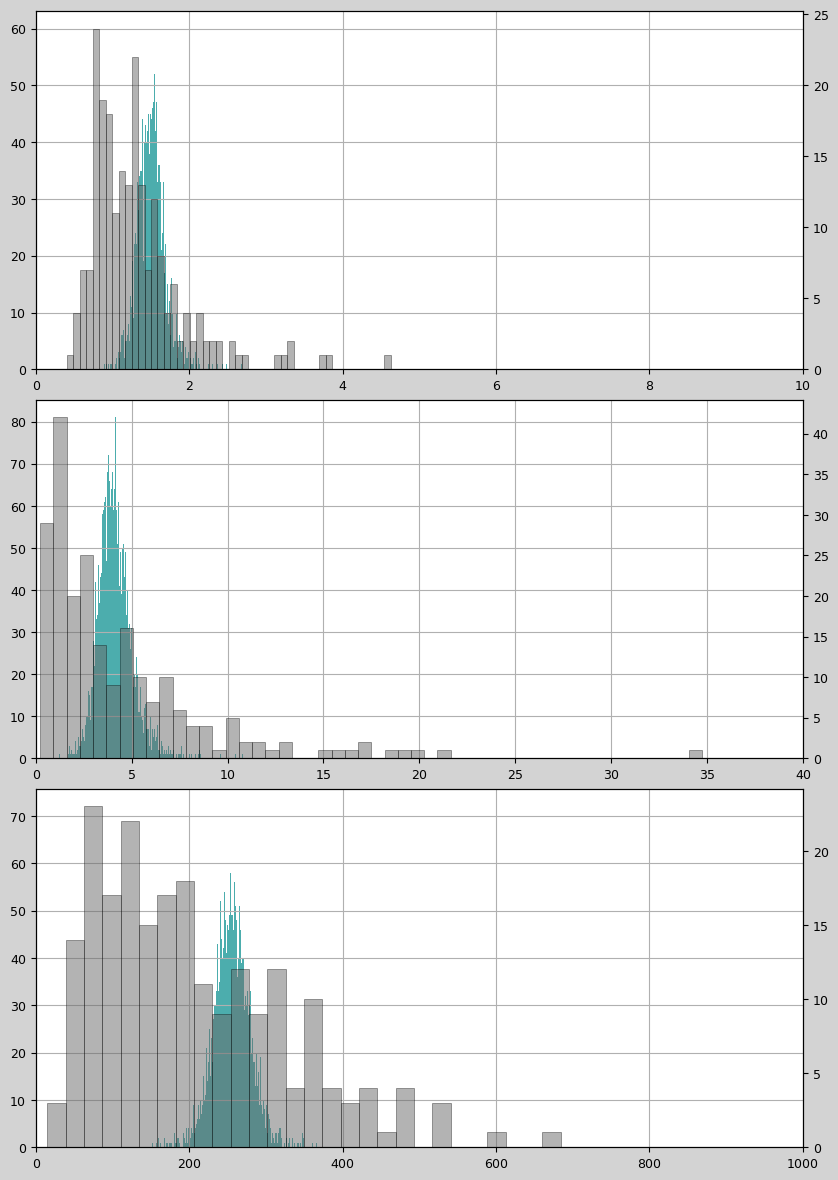

In [20]:
a4_width = 8.27  # inches
a4_height = 11.69  # inches

fig = plt.figure(figsize=(a4_width, a4_height), layout='constrained')

L1 = GridSpec(3,1, figure=fig)#, width_ratios=[1, 1,1,1], height_ratios=[1,1, 1])

ax1 = fig.add_subplot(L1[2,0])
ax2 = fig.add_subplot(L1[0,0])
ax3 = fig.add_subplot(L1[1,0])
plt.style.use(custom_style)

# Histograma comparativo

bins = 1000
ax1.hist(media_ih, bins, alpha=0.7, facecolor="darkcyan")
ax1 = ax1.twinx()
ax1.hist(media_real_ih,200, alpha=0.5, facecolor="dimgray", edgecolor="black", linewidth=0.5)
ax1.set_xlim(0,1000)
ax1.set_xlabel("IH", fontsize=14)
ax1.grid(False)
plt.style.use(custom_style)

ax2.hist(media_cot, bins,  alpha=0.7, facecolor="darkcyan")
ax2 = ax2.twinx()
ax2.hist(media_real_cot,50, alpha=0.5, facecolor="dimgray", edgecolor="black", linewidth=0.5)
ax2.set_xlim(0,10)
ax2.set_xlabel("COT", fontsize=14)
ax2.grid(False)
plt.style.use(custom_style)

ax3.hist(media_spi, bins,  alpha=0.7, facecolor="darkcyan")
ax3 = ax3.twinx()
ax3.hist(media_real_s2,50, alpha=0.5, facecolor="dimgray", edgecolor="black", linewidth=0.5)
ax3.set_xlim(0,40)
ax3.set_xlabel("S2", fontsize=14)
ax3.grid(False)
plt.style.use(custom_style)


### Faixas de valores de COT por análise estatística

In [21]:
#f1 = []
#f2 = []
#f3 = []
#f4 = []
#for i in concat_df["COT"]:
#    if i > 2.9 and i <=4:
#        f1.append(i)
#    elif i > 4 and i <= 6:
#        f2.append(i)
#    elif i > 6 and i < 10:
#        f3.append(i)
#    elif i <=2.9:
#        f4.append(i)
#cont1=len(f1)
#cont2=len(f2)
#cont3=len(f3)
#cont4=len(f4)
#p1=(cont1/17584)*100
#p2=(cont2/17584)*100
#p3=(cont3/17584)*100
#p4=(cont4/17584)*100
#print(cont1, cont2, cont3, cont4)
#print(p1,p2,p3,p4)
#print(p1+p2+p3)    

In [22]:
#F1 = []
#F2 = []
#F3 = []
#F4 = []
#for index, row in concat_df.iterrows():
#    i = row["COT"]
#    j = row["S2"]
#    if i > 2.9 and i <=4 and j > 0  and j < 4.85*i:
#        F1.append(i)
#    elif i > 4 and i <= 6 and j > 0  and j < 4.85*i:
#        F2.append(i)
#    elif i > 6 and i < 10 and j > 0  and j < 4.85*i:
#        F3.append(i)
#    elif i <=2.9 and j > 0  and j < 4.85*i:
#        F4.append(i)
#Cont1=len(F1)
#Cont2=len(F2)
#Cont3=len(F3)
#Cont4=len(F4)
#P1=(Cont1/cont1)*100
#P2=(Cont2/cont2)*100
#P3=(Cont3/cont3)*100
#P4=(Cont4/cont4)*100
#print(Cont1, Cont2, Cont3, Cont4)
#print(P1,P2,P3,P4)


## Aba maturação adaptada aos poços simulados

In [23]:
def maturation():
    df_names = pd.read_csv("Poços_Simu.csv")
    for index, row in df_names.iterrows():
        poço = row["Poço"]
     
        df1 = pd.read_csv("Poços_Simulados/"+poço+".csv")
        df=df1[["COTf","S1","S2pi","S3","Tmax","IHf","IO"]]

        #======================================================================================================================================================#

        # Agrupamento para Cálculo de COTa

        num_clusters = 3                                                             # Number of clusters you want to create
        def cluster(df, col_COT, col_S1, col_S2, col_S3, col_Tmax):                                                            
            X = df[[col_COT, col_S1, col_S2, col_S3, col_Tmax]].fillna(0)            # Extract the columns for clustering
            kmeans = KMeans(n_clusters=num_clusters, random_state=42)                # Apply k-means clustering
            kmeans.fit(X)                                                            # Use X_scaled if you scaled the data, otherwise use X
            cluster_labels = kmeans.labels_                                          # Get cluster assignments and centroids
            centroids = kmeans.cluster_centers_    
            df['Cluster'] = cluster_labels                                           # Add cluster labels to the original data frame
            df1=df.dropna(subset=[col_COT,col_S2])                                   # Extract data from DataFrame
            x_data = df1[col_S2].values.reshape(-1, 1)  
            y_data = df1[col_COT].values
            model = LinearRegression()                                               # Fit linear regression model
            model.fit(x_data, y_data)
            slope = model.coef_[0]                                                   # Get the slope (coefficient) and y-intercept of the trend line
            intercept = model.intercept_           
        cluster(df, "COTf","S1","S2pi","S3","Tmax")

        # Regressão linear para cálculo de COTa
        # Cálculo de COTa

        def COT_a(df, col_cluster, col_cot, col_S2):
            models = {}
            for cluster_id in range(num_clusters):
                cluster_data = df[df[col_cluster] == cluster_id]
                x_values = cluster_data[[col_S2]].fillna(value=0)
                y_values = cluster_data[col_cot]
                model = LinearRegression()
                model.fit(x_values, y_values)
                models[cluster_id] = model
            dic={}                                                                    # Print the linear regression equations for each cluster
            for cluster_id, model in models.items():
                slope = model.coef_[0]
                intercept = model.intercept_
                dic[cluster_id]=intercept
            COTativo=[]
            for idx,row in df.iterrows():
                #print(row["Cluster"])
                Cluster=row[col_cluster]
                COT=row[col_cot]
                intercept=dic[Cluster]
                COTa= COT- intercept
                COTativo.append(COTa)
            df["COTa"]=COTativo
            COT_cor=[]
            for i in df["COTa"]:
                if i >= 0:
                    COT_cor.append(i)
                else:
                    COT_cor.append(0)
            df["COTa"]=COT_cor
            return df
        df=COT_a(df, "Cluster", "COTf", "S2pi")

        # Cálculo de IHa

        def IH0a(df, col_S2, col_COTa):
            IHa = (100*df[col_S2]/df[col_COTa])
            IHa_cor=[]
            for i in IHa:
                if i<0:
                    IHa_cor.append(0)
                elif i>999:
                    IHa_cor.append(999)
                else:
                    IHa_cor.append(i)                                                  # Eliminar valores
            df["IH0a"]= IHa_cor
            return df
        IH0a(df, "S2pi", "COTa")
        
        # Taxa de Transformação sem Ro (IH)

        def Tr_IH(df, col_IH0a, col_IH):
            df["Taxa de Transformação (IH)"] = ((df[col_IH0a]-df[col_IH])/df[col_IH0a])
            TrIH=[]
            for i in df["Taxa de Transformação (IH)"]:
                if i<0:
                    TrIH.append(0)
                elif i>1:
                    TrIH.append=1
                else:
                    TrIH.append(i)
            df["Taxa de Transformação (IH)"]=TrIH
            return df
        Tr_IH(df, "IH0a","IHf")

        # Cálculo de COT0, S20, IH0, OSI e S2/S3

        def COT0(df, col_TrIH, col_S1, col_S2, col_COT):
            Tr = df["Taxa de Transformação (IH)"]
            df["S20"]=df["S2pi"]/(1-Tr)
            df["COT0"]=df["COTf"]+((df["S2pi"]*Tr)/(1-Tr))*0.086
            df["IH0"]=100*df["S20"]/df["COT0"]
            IH0=[]
            for i in df["IH0"]:
                if i >1000:
                    i=1000
                else:
                    i=i
                IH0.append(i)
            df["IH0"]=IH0
        COT0(df, "Taxa de Transformação (IH)", "S1","S2pi", "COTf")

        #=========================================================================#
        #========================= PLANILHA DE OUTPUT ============================#

        def out_plan(df, col_COT, col_S1, col_S2, col_S3, col_Tmax, col_IH, col_IO, col_cluster, col_COTa, col_IH0a, col_COT0, col_S20, col_IH0):
            IP0=0.02
                            
            
            df_csv=df[[col_COT, col_S1, col_S2, col_S3, col_Tmax, col_IH, col_IO, col_cluster]]
            df_csv[[col_COTa, col_IH0a]]=df[["COTa","IH0a"]].round(2)
            df_csv[[col_COT0, col_S20, col_IH0]]=df[["COT0","S20","IH0"]].round(2)
            df_csv["Índice de Produção"]=(df[col_S1]/(df[col_S1]+df[col_S2])).round(2)
            df_csv["f"] = (1-(df[col_IH]*(1200-(df[col_IH0]/(1-IP0))))/(df[col_IH0]*(1200-(df[col_IH]/(1-df_csv["Índice de Produção"]))))).round(2)
            df_csv["S1 expelido (barris/acre)"] = (((1000*(df[col_COT0]-df[col_COT]))/(83.33-df[col_COT])/850)*7758*10).round(2)
            df_csv["Eficiência de Expulsão (%)"] = ((1 - (((1-df_csv["f"])*(df_csv["Índice de Produção"]/(1-df_csv["Índice de Produção"])))/(df_csv["f"]+(IP0/(1-IP0)))))*100).round(2)
            ExEf_cor=[]
            for i in df_csv["Eficiência de Expulsão (%)"]:
                if i<0:
                    ExEf_cor.append(0)
                elif i>100:
                    ExEf_cor.append(100)
                else:
                    ExEf_cor.append(i)
            ExEf=pd.DataFrame(ExEf_cor)
            df_csv["Eficiência de Expulsão (%)"]=ExEf

            #=== Export. csv =====#
            
            df_csv.to_csv("Outputs_Simu/"+poço+".csv")
            return df_csv
        out_plan(df, "COTf","S1","S2pi","S3","Tmax","IHf","IO","Cluster", "COTa","IH0a", "COT0","S20","IH0") 
#maturation()
            

### Criação da planilha "Nomes_Simu"

In [24]:
#n = 10000
#cont = 0
#p = []
#while cont <n:
#    p.append(f"Poço_{cont+1}")
#    cont+=1
#dfp = pd.DataFrame({"Poço":p})
#dfp.to_csv("Poços_Simu.csv")


## Avaliação dos parâmetros calculados pela aba maturação

#### Concatenagem dos poços simulados e reais

In [25]:
simulados = "Outputs_Simu"
csv_files = [file for file in os.listdir(simulados) if file.endswith('.csv')] 

dataframes1 = []

for csv_file in csv_files:                              # Concatenagem das planilhas importadas
    file_path = os.path.join(simulados, csv_file)
    df = pd.read_csv(file_path)
    dataframes1.append(df)
dfc_simu= pd.concat(dataframes1, ignore_index=True)
#dfc_simu

reais = "Outputs_Planilhas"
csv_files = [file for file in os.listdir(reais) if file.endswith('.csv')] 

dataframes2 = []

for csv_file in csv_files:                              # Concatenagem das planilhas importadas
    file_path = os.path.join(reais, csv_file)
    df = pd.read_csv(file_path)
    dataframes2.append(df)
dfc_real= pd.concat(dataframes2, ignore_index=True)
#dfc_real

In [26]:
corrs_df=dfc_simu[["COTf","S1","S2pi","S3","IHf","IO","Tmax","COTa","COT0","S20","IH0"]]
corrs_df.corr()

,COTf,S1,S2pi,S3,IHf,IO,Tmax,COTa,COT0,S20,IH0
COTf,1.000000,0.000636,0.768322,-0.000867,0.175645,-2.663019e-04,1.035978e-04,0.532812,0.975199,0.666549,-0.315130
S1,0.000636,1.000000,-0.000288,0.002290,-0.001477,-6.798880e-04,-3.115692e-04,0.001392,0.000293,-0.000802,-0.001518
S2pi,0.768322,-0.000288,1.000000,-0.001451,0.613180,-5.006844e-04,-8.162374e-04,0.416980,0.807005,0.926601,0.241935
S3,-0.000867,0.002290,-0.001451,1.000000,-0.001889,1.794460e-01,-1.600084e-03,0.001340,-0.000744,-0.000993,-0.000814
IHf,0.175645,-0.001477,0.613180,-0.001889,1.000000,-1.144902e-03,-1.968209e-03,0.109116,0.241364,0.610504,0.708188
IO,-0.000266,-0.000680,-0.000501,0.179446,-0.001145,1.000000e+00,-5.378752e-07,0.000539,-0.000465,-0.000674,0.000378
Tmax,0.000104,-0.000312,-0.000816,-0.001600,-0.001968,-5.378752e-07,1.000000e+00,0.000905,-0.000014,-0.000640,-0.000580
COTa,0.532812,0.001392,0.416980,0.001340,0.109116,5.387886e-04,9.047456e-04,1.000000,0.479831,0.288307,-0.178596
COT0,0.975199,0.000293,0.807005,-0.000744,0.241364,-4.652520e-04,-1.399823e-05,0.479831,1.000000,0.783246,-0.176212
S20,0.666549,-0.000802,0.926601,-0.000993,0.610504,-6.740704e-04,-6.404488e-04,0.288307,0.783246,1.000000,0.393936


(0.0, 250.0)

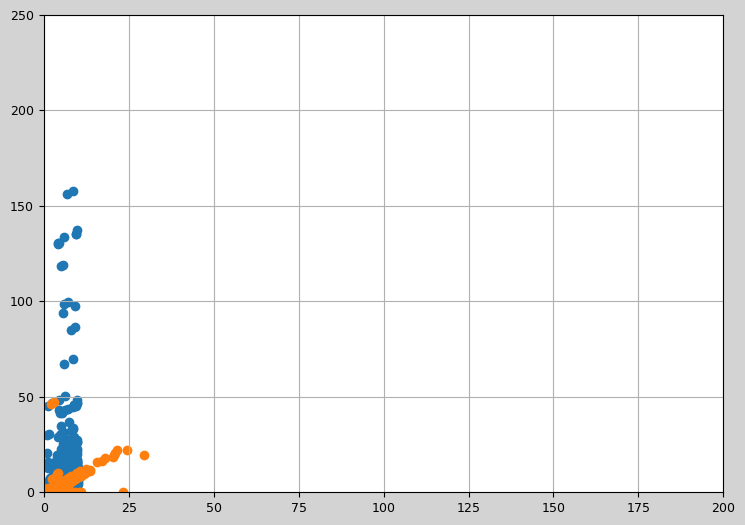

In [27]:
plt.scatter(dfc_simu["COTf"],dfc_simu["COTa"])
plt.scatter(dfc_real["COT"],dfc_real["COTa"])
plt.xlim(0,200)
plt.ylim(0,250)

In [28]:
media_cot0=[]
for csv_file in csv_files:
    file_path = os.path.join(simulados, csv_file)
    df = pd.read_csv(file_path)
    avg = df["COT0"].mean()
    media_ih.append(avg)

media_s20=[]
for csv_file in csv_files:
    file_path = os.path.join(simulados, csv_file)
    df = pd.read_csv(file_path)
    avg = df["S20"].mean()
    media_cot.append(avg)

media_ih0=[]
for csv_file in csv_files:
    file_path = os.path.join(simulados, csv_file)
    df = pd.read_csv(file_path)
    avg = df["IH0"].mean()
    media_spi.append(avg)

# Importação de poços reais
dataframes3=[]
directory_path = "Outputs_Planilhas"
csv_files = [file for file in os.listdir(directory_path) if file.endswith('.csv')]   # Lista com os nomes de todos os arquivos importados
for csv_file in csv_files:
    file_path = os.path.join(directory_path, csv_file)
    df = pd.read_csv(file_path)
    dataframes3.append(df)
concat_df= pd.concat(dataframes3, ignore_index=True)

# Cálculo das médias de poços reais

media_real_ih0=[]
for csv_file in csv_files:
    file_path = os.path.join(directory_path, csv_file)
    df = pd.read_csv(file_path)
    avg = df["IH0"].mean()
    media_real_ih.append(avg)

media_real_cot0=[]
for csv_file in csv_files:
    file_path = os.path.join(directory_path, csv_file)
    df = pd.read_csv(file_path)
    avg = df["COT0"].mean()
    media_real_cot.append(avg)

media_real_s20=[]
for csv_file in csv_files:
    file_path = os.path.join(directory_path, csv_file)
    df = pd.read_csv(file_path)
    avg = df["S20"].mean()
    media_real_s2.append(avg)



FileNotFoundError: [Errno 2] No such file or directory: 'Outputs_Simu/1-RNS-37-RN.csv'